Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# MONAI Active Learning Uncertainty Exploration & Results Analysis

There are two sections in this notebook:
    
1.) How to visualize uncertainty from given unlabeled samples

2.) How to analyze results once the active learning scripts have been run to completion

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [3]:
import os
import json
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt

from monai.config import print_config
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.inferers import sliding_window_inference
from monai.data import DataLoader, Dataset
from monai.transforms import (
    CropForegroundd,
    Compose,
    EnsureTyped,
    EnsureChannelFirstd,
    LoadImaged,
    ScaleIntensityRanged,
    Spacingd,
)

print_config()

MONAI version: 1.0.1
Numpy version: 1.23.4
Pytorch version: 1.13.0+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8271a193229fe4437026185e218d5b06f7c8ce69
MONAI __file__: /home/vishwesh/anaconda3/envs/mtk_py38/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.3.0
Tensorboard version: 2.11.0
gdown version: 4.5.3
TorchVision version: 0.14.0+cu117
tqdm version: 4.64.1
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.5.1
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.0.1
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Part 1: Uncertainty Visualization

Visualization of the spatial uncertainty maps provides an understanding of what particular regions of the unlabeled image the model is not confident about. The below example will showcase uncertainty on a few examples from the training set.

### Dataset, Model and Transform Definitions

In [5]:
# Paths, to be defined by user
data_root = os.path.normpath("/to/be/defined")
json_path = os.path.normpath("/to/be/defined")
model_ckpt = os.path.normpath("/to/be/defined")

# Load Json file
with open(json_path, "rb") as f:
    json_data = json.load(f)
f.close()

unl_transforms = Compose(
    [
        LoadImaged(keys=("image")),
        EnsureChannelFirstd(keys=("image")),
        Spacingd(
            keys=("image"),
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear"),
        ),
        ScaleIntensityRanged(keys="image", a_min=-21, a_max=189, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=("image"), source_key="image"),
        EnsureTyped(keys=["image"]),
    ]
)

# Append data paths to data root
unl_d = json_data["training"]
for idx, _each_sample in enumerate(unl_d):
    unl_d[idx]["image"] = os.path.join(data_root, unl_d[idx]["image"])
    unl_d[idx]["label"] = os.path.join(data_root, unl_d[idx]["label"])

# Create Dataloader
unl_ds = Dataset(data=unl_d, transform=unl_transforms)
unl_loader = DataLoader(unl_ds, batch_size=1, shuffle=False)

# Model Definition
device = torch.device("cuda")

model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
    dropout=0.2,
).cuda()

# Load Model Weights
model.load_state_dict(torch.load(model_ckpt))

# Please note that the model is being put to 'train' mode explicitly for Monte-Carlo simulations
model.train()
print("We are set to visualize some cool uncertainty ...")

monai.networks.nets.unet UNet.__init__:dimensions: Argument `dimensions` has been deprecated since version 0.6. Please use `spatial_dims` instead.


We are set to visualize some cool uncertainty ...


(299, 247, 340)


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


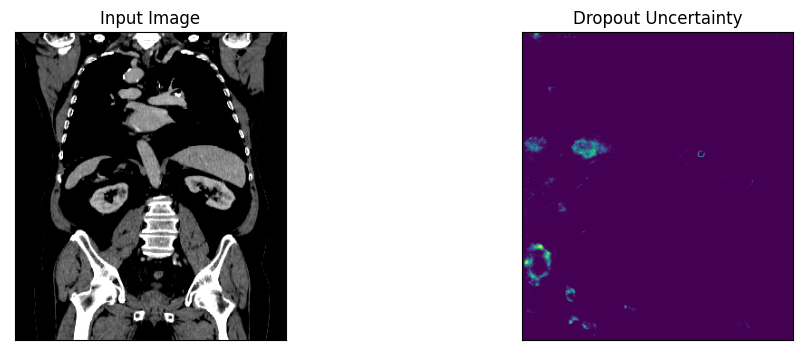

In [28]:
with torch.no_grad():
    counter = 1
    for unl_data in unl_loader:
        counter = counter + 1
        if counter == 4:
            unl_inputs = unl_data["image"].to(device)

            roi_size = (160, 160, 160)
            sw_batch_size = 4

            accum_unl_outputs = []

            for _mc in range(3):
                unl_outputs = sliding_window_inference(unl_inputs, roi_size, sw_batch_size, model)

                # Activate the output with Softmax
                unl_act_outputs = torch.softmax(unl_outputs, dim=1)

                # Accumulate
                accum_unl_outputs.append(unl_act_outputs)

            # Stack it up, Squeeze and send to CPU
            accum_tensor = torch.stack(accum_unl_outputs)
            accum_tensor = torch.squeeze(accum_tensor)
            accum_numpy = accum_tensor.to("cpu").numpy()
            accum_numpy = accum_numpy[:, 1:, :, :, :]

            # The input is assumed with repetitions, channels and then volumetric data
            vol_input = accum_numpy.astype(dtype="float32")
            dims = vol_input.shape

            # Threshold values less than or equal to zero
            threshold = 0.0005
            vol_input[vol_input <= 0] = threshold

            vari = np.nanvar(vol_input, axis=0)
            variance = np.sum(vari, axis=0)
            variance_dims = np.shape(variance)

            show_img = np.squeeze(unl_inputs.to("cpu").numpy())
            print(show_img.shape)
            # Plot with matplotlib
            plt.figure(1, figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(np.rot90(np.squeeze(show_img[:, np.int(variance_dims[1] / 2), :]), 1), cmap="gray")
            plt.xticks([])
            plt.yticks([])
            plt.title("Input Image")
            plt.subplot(1, 2, 2)
            plt.imshow(np.rot90(np.squeeze(variance[:, np.int(variance_dims[1] / 2), :]), 1))
            plt.xticks([])
            plt.yticks([])
            plt.title("Dropout Uncertainty")
            plt.show()
            break

## Part 2: Results Analysis

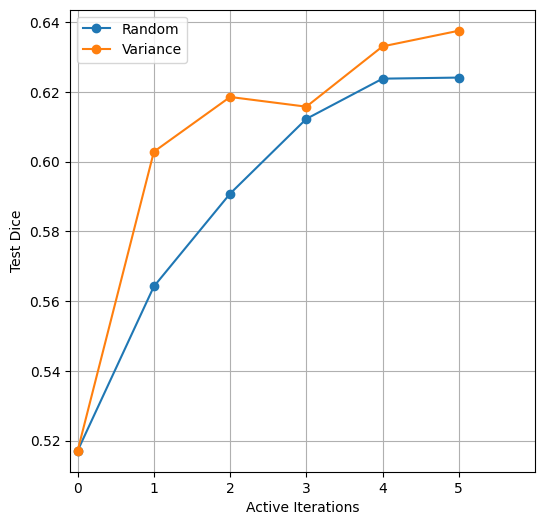

In [29]:
base_path = os.path.normpath("/to/be/defined/results/path/from/runner.sh/goes/here")

method_name_list = {
    "random_i5_q5_iter2k": "Random",
    "variance_i5_q5_iter2k": "Variance",
}

active_iters = 6
x = range(0, active_iters)
legend_list = []

plt.figure(1, figsize=(6, 6))
for each_method, legend_name in method_name_list.items():
    method_path = os.path.join(base_path, each_method)
    legend_list.append(legend_name)
    per_active_dice_score = []

    trial_path = os.path.join(base_path, each_method)
    print("Working on {}".format(trial_path))
    pickle_path = os.path.join(trial_path, "all_metrics.pickle")
    with open(pickle_path, "rb") as handle:
        data = pickle.load(handle)
    handle.close()
    for each_iter in range(active_iters):
        iter_key = "model_" + str(each_iter)
        max_val = np.max(data[iter_key]["test_dice"])

        per_active_dice_score.append(max_val)

    plt.plot(x, per_active_dice_score, "-o")

# Get Full dataset result
all_data_result_path = os.path.join(base_path, "all_data_iter2k", "all_metrics.pickle")
with open(all_data_result_path, "rb") as handle:
    all_data_result = pickle.load(handle)
handle.close()
all_data_score = all_data_result["model_0"]["test_dice"]
all_data_list = [all_data_score] * active_iters
plt.errorbar(list(range(0, active_iters)), all_data_list, fmt="--", ecolor="black")
legend_list.append("All Data Supervised")

plt.grid()
plt.xlabel("Active Iterations")
plt.ylabel("Test Dice")
plt.xlim([-0.1, active_iters])
plt.xticks(list(range(0, active_iters)))
plt.legend(legend_list)
plt.show()